## Baseling LSTM

### [Kaggle Competition](https://www.kaggle.com/competitions/ventilator-pressure-prediction/overview)

In [23]:
import os
import gc
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from collections import Counter

import torch
import torch.nn as nn

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 18})
plt.style.use('ggplot')
import seaborn as sns
from scipy import stats

from sklearn.model_selection import GroupKFold

warnings.filterwarnings("ignore")
NUM_WORKERS = 4

from utils import *
from train import *


## Data Overview

Columns
* id - globally-unique time step identifier across an entire file
* breath_id - globally-unique time step for breaths

* R - lung attribute indicating how restricted the airway is (in cmH2O/L/S). Physically, this is the change in pressure per change in flow (air volume per time). Intuitively, one can imagine blowing up a balloon through a straw. We can change R by changing the diameter of the straw, with higher R being harder to blow.
  The variable R is resistance and indicates how easy it is for air to enter and then "exit" the balloon. (Actually just move around since during inhale exit is closed). The largest value R=50 has the most resistance. If we input air into a balloon with high resistance, the air "stays inside" and increases pressure.
  If we input a spike (quick input) of air, then the balloons (lungs) with large R rise in pressure quickly while the balloons (lungs) with small R observe the air "passing though" easily and do not rise in pressure quickly.

* C - lung attribute indicating how compliant the lung is (in mL/cmH2O). Physically, this is the change in volume per change in pressure. Intuitively, one can imagine the same balloon example. We can change C by changing the thickness of the balloon’s latex, with higher C having thinner latex and easier to blow.
  The variable C is compliance and indicates how easy it is to stretch the balloon (lung). The largest value C=50 is the easiest to stretch. If we input air into a balloon that stretches easily, the pressure does not increase because the balloon just gets bigger (and thus air per space does not increase). If we input air into a ballon that does not stretch easy (C=10), the balloon stays the same size but gets more air inside (thus pressure increases).



* time_step - the actual time stamp.

* u_in - the control input for the inspiratory solenoid valve. Ranges from 0 to 100.

* u_out -This is the second control input for the expiratory solenoid valve. It is a binary variable representing whether the expioratory valve is open (1) or closed (0) to let air out. u_out=1 is the expiratory phase. In simple terms, expiratory phase, is "breath out" or in the case of an artificial lung, let the air out. The data for the expiratory phase is not helpful for the model. During an exhale, the ventilator pressure and the target pressure are nearly identical.
  
  Read more - https://www.kaggle.com/competitions/ventilator-pressure-prediction/discussion/273906

* pressure - the airway pressure measured in the respiratory circuit, measured in cmH2O.




--------------------

## Parameters R and C Explanation

https://www.kaggle.com/competitions/ventilator-pressure-prediction/discussion/276599

## Goal

The goal is to simulate a ventilator connected to a sedated patient's lung by taking lung attributes compliance and resistance into account.

In [24]:
# ROOT_DIR = "/kaggle/input/ventilator-pressure-prediction/" # Kaggle
ROOT_DIR = "../input/" # Local

sub = pd.read_csv(ROOT_DIR + 'sample_submission.csv')
df_train = pd.read_csv(ROOT_DIR + 'train.csv')
df_test = pd.read_csv(ROOT_DIR + 'test.csv')

In [25]:
df_train.head()

,id,breath_id,R,C,time_step,u_in,u_out,pressure
0,1,1,20,50,0.000000,0.083334,0,5.837492
1,2,1,20,50,0.033652,18.383041,0,5.907794
2,3,1,20,50,0.067514,22.509278,0,7.876254
3,4,1,20,50,0.101542,22.808822,0,11.742872
4,5,1,20,50,0.135756,25.355850,0,12.234987


In [26]:
df_train['breath_id'].unique().shape

(75450,)

In [27]:
df_train = df_train[df_train['breath_id'] < 3].reset_index(drop=True)

In [28]:
df_train['breath_id'].unique().shape

(2,)

In [29]:
df_train.shape

(160, 8)

<Axes: >

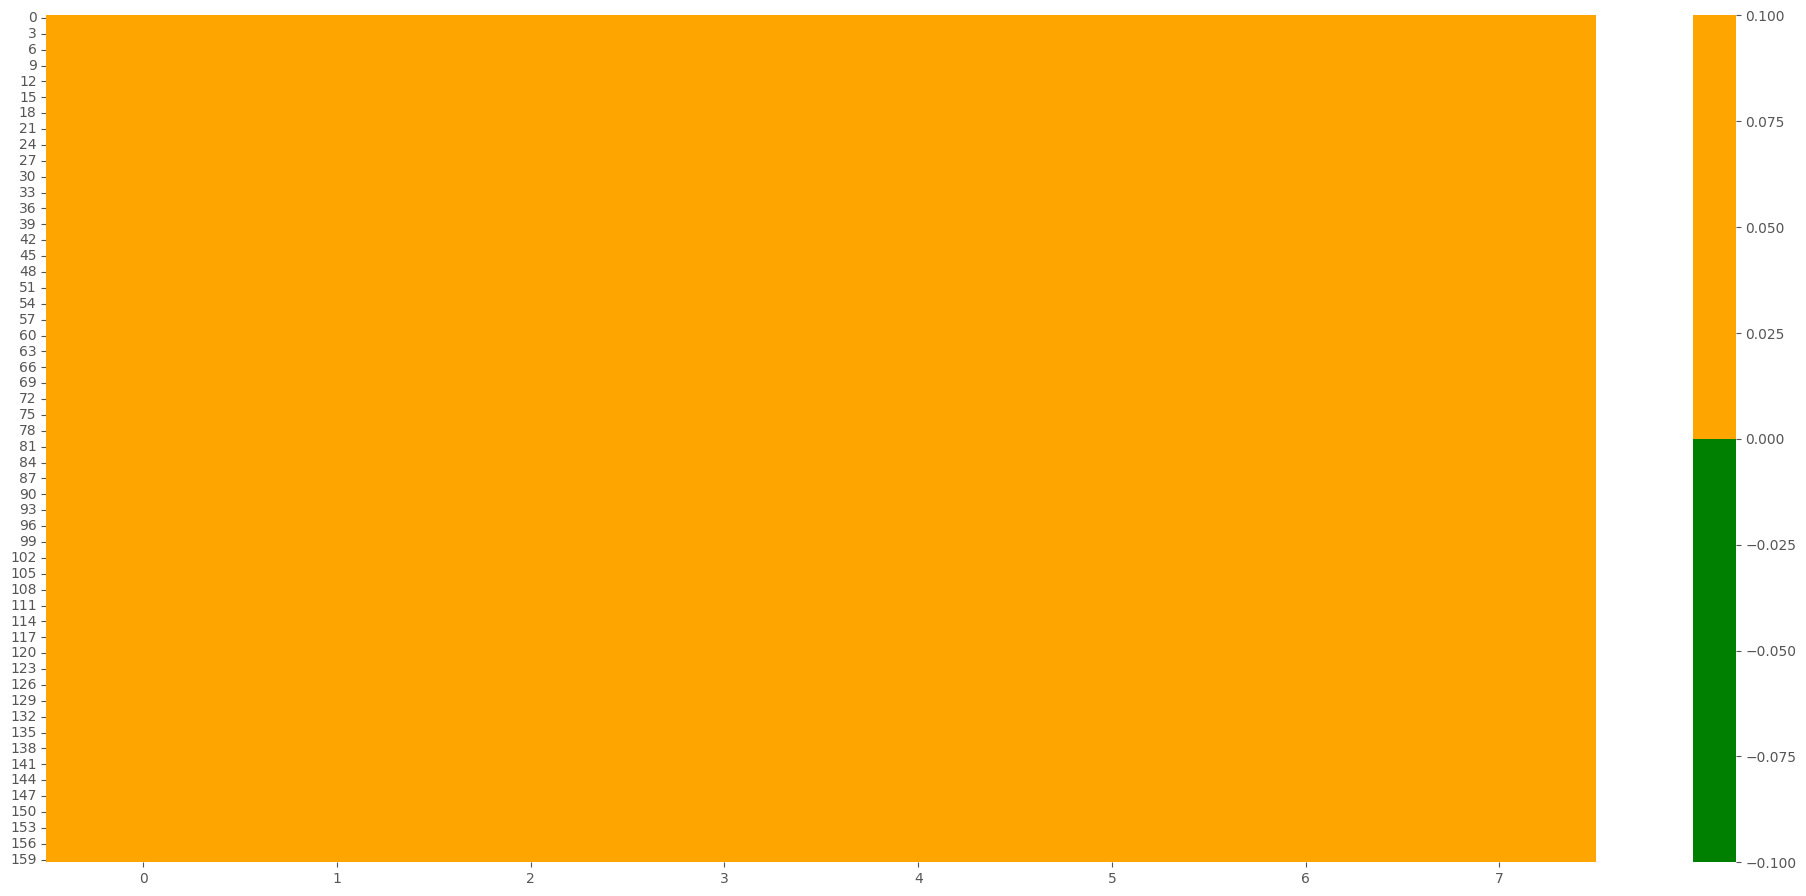

In [33]:
plt.figure(figsize = (25,11))
# sns.heatmap(df.isna().values, cmap = ['green','orange'], xticklabels=df_train.columns)
sns.heatmap(df_train.isna().values, cmap = ['green','orange'])
# plt.title("Missing values in training Data", size=20);

In [34]:
def plot_sample(sample_id, df):
    df_breath = df[df['breath_id'] == sample_id]
    r, c  = df_breath[['R', 'C']].values[0]

    cols = ['u_in', 'u_out', 'pressure'] if 'pressure' in df.columns else ['u_in', 'u_out']
    
    plt.figure(figsize=(12, 4))
    for col in cols:
        plt.plot(df_breath['time_step'], df_breath[col], label=col)
        
    plt.legend()
    plt.title(f'Sample {sample_id} - R={r}, C={c}')

In [35]:
df_train['breath_id'].unique() # there are only 4 unique breath ids

array([1, 2], dtype=int64)

In [ ]:
for i in df_train['breath_id'].unique():
    plot_sample(i, df_train)

## Prepare Data for LSTM


In [37]:
dataset = VentilatorDataset(df_train)
dataset[0]

{'input': tensor([[2.0000e+01, 5.0000e+01, 8.3334e-02, 8.3334e-02, 0.0000e+00],
         [2.0000e+01, 5.0000e+01, 1.8383e+01, 1.8466e+01, 0.0000e+00],
         [2.0000e+01, 5.0000e+01, 2.2509e+01, 4.0976e+01, 0.0000e+00],
         [2.0000e+01, 5.0000e+01, 2.2809e+01, 6.3784e+01, 0.0000e+00],
         [2.0000e+01, 5.0000e+01, 2.5356e+01, 8.9140e+01, 0.0000e+00],
         [2.0000e+01, 5.0000e+01, 2.7260e+01, 1.1640e+02, 0.0000e+00],
         [2.0000e+01, 5.0000e+01, 2.7127e+01, 1.4353e+02, 0.0000e+00],
         [2.0000e+01, 5.0000e+01, 2.6808e+01, 1.7034e+02, 0.0000e+00],
         [2.0000e+01, 5.0000e+01, 2.7865e+01, 1.9820e+02, 0.0000e+00],
         [2.0000e+01, 5.0000e+01, 2.8313e+01, 2.2651e+02, 0.0000e+00],
         [2.0000e+01, 5.0000e+01, 2.6867e+01, 2.5338e+02, 0.0000e+00],
         [2.0000e+01, 5.0000e+01, 2.6763e+01, 2.8014e+02, 0.0000e+00],
         [2.0000e+01, 5.0000e+01, 2.7993e+01, 3.0814e+02, 0.0000e+00],
         [2.0000e+01, 5.0000e+01, 2.6790e+01, 3.3493e+02, 0.0000e+00

## Model

In [38]:
class Config:
    """
    Parameters used for training
    """
    # General
    seed = 42
    verbose = 1
    device = "cuda" if torch.cuda.is_available() else "cpu"
    save_weights = True

    # k-fold
    k = 5
    selected_folds = [0, 1, 2, 3, 4]
    
    # Model
    selected_model = 'rnn'
    input_dim = 5

    dense_dim = 512
    lstm_dim = 512
    logit_dim = 512
    num_classes = 1

    # Training
    loss = "L1Loss"  # not used
    optimizer = "Adam"
    batch_size = 128
    epochs = 200

    lr = 1e-3
    
    warmup_prop = 0

    val_bs = 256
    first_epoch_eval = 0

In [ ]:
pred_oof, pred_test = k_fold(
    Config, 
    df_train,
    df_test,
)

### Predictions

In [40]:
df_train["pred"] = pred_oof

In [ ]:
for i in df_train['breath_id'].unique()[:5]:
    plot_prediction(i, df_train)

## Sub

In [ ]:
df_test['pred'] = pred_test

for i in df_test['breath_id'].unique()[:5]:
    plot_prediction(i, df_test)

In [43]:
sub['pressure'] = pred_test
sub.to_csv('submission.csv', index=False)